## GDR: marker Gene-guided Dimensionality Reduction

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import os
from typing import Iterable, Union, Optional
import matplotlib.pyplot as plt
import anndata as ad
import logging
from matplotlib import rcParams
import seaborn as sns
from matplotlib import cm
from matplotlib import colors, colorbar
from scib_metrics.benchmark import Benchmarker
import scib_metrics as sb
import time
import warnings

In [2]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
path = '/home/vas744/Analysis/Python/Packages/PIASO'
import sys
sys.path.append(path)
import piaso

In [4]:
sc.set_figure_params(dpi=96,dpi_save=300, color_map='viridis',facecolor='white')
rcParams['figure.figsize'] = 4, 4
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "Arial"
sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.10.3 anndata==0.10.8 umap==0.5.7 numpy==1.26.4 scipy==1.12.0 pandas==2.2.3 scikit-learn==1.5.2 statsmodels==0.14.4 igraph==0.11.8 louvain==0.8.2 pynndescent==0.5.13


### Load the data

We will be using a Multiome RNA dataset obtained from cortex at P57.

Download the dataset from Google Drive: https://drive.google.com/file/d/1bEyWNjGvoA9kz3J6jnbXRKgAIytb555W/view?usp=drive_link

In [5]:
!/home/vas744/Software/gdrive files download --destination /n/scratch/users/v/vas744/Data/Public/PIASO 1bEyWNjGvoA9kz3J6jnbXRKgAIytb555W

Successfully downloaded AdultCortexMultiomeRNA_integrated_anno.h5ad


In [5]:
adata_path = os.path.join("/n/scratch/users/v/vas744/Data/Public/PIASO", "AdultCortexMultiomeRNA_integrated_anno.h5ad")

In [6]:
adata = sc.read(
    adata_path,
)
adata

AnnData object with n_obs × n_vars = 17412 × 26205
    obs: 'gex_barcode', 'atac_barcode', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'Sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'pct_counts_ribo', 'scrublet_score', 'predicted_doublets', 'scrublet_cluster_score', 'bh_pval', 'Leiden', 'Leiden_last', 'Leid

### INFOG normalization

In [7]:
%%time
piaso.tl.infog(adata,
               layer='raw',
               n_top_genes=3000,)

/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_normalization.py:41: RuntimeWarning: divide by zero encountered in divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gene_depth.ravel())


The normalized data is saved as `infog` in `adata.layers`.
The highly variable genes are saved as `highly_variable_infog` in `adata.obs`.
Finished INFOG normalization.
CPU times: user 3.21 s, sys: 1.92 s, total: 5.13 s
Wall time: 5.23 s


### Visualize with PCA-based UMAP
First, we will use a standard PCA-based UMAP to visualize the batches and cell types in the dataset. This helps in assessing the presence of batch effects.

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:23)


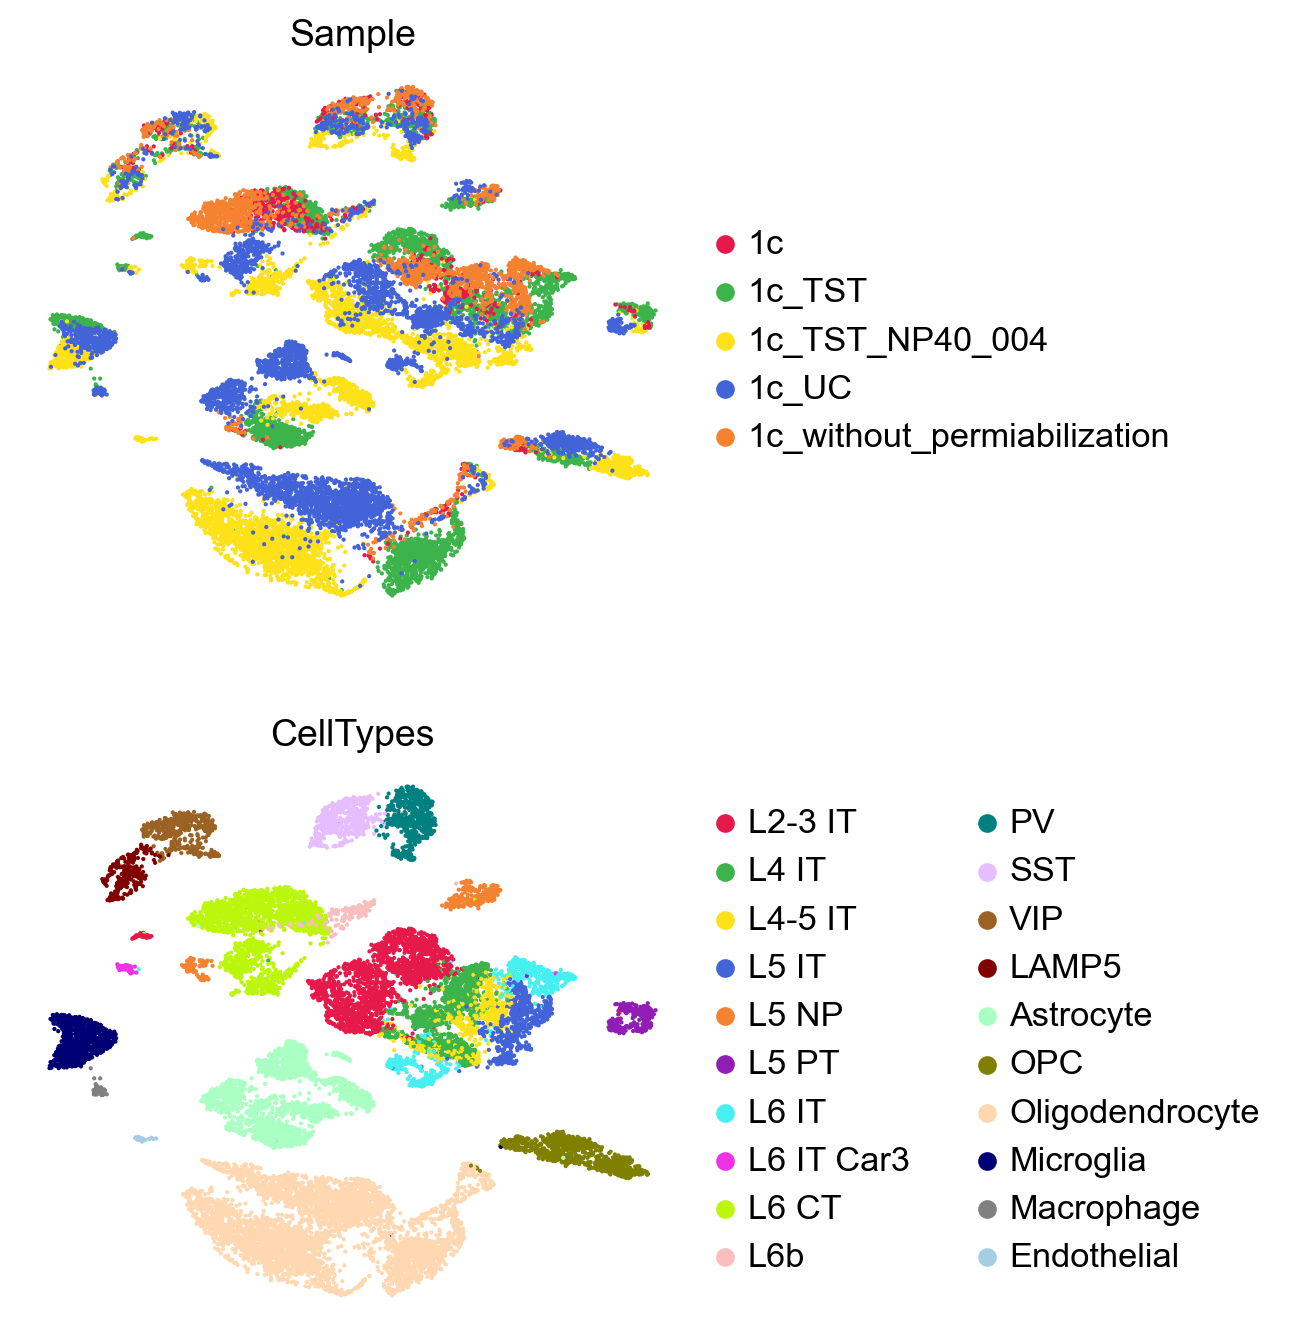

In [8]:
sc.pp.neighbors(adata,
                use_rep='X_pca',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")

sc.tl.umap(adata)

sc.pl.umap(adata,
           color=['Sample','CellTypes'],
           palette=piaso.pl.color.d_color4,
           cmap=piaso.pl.color.c_color4,
           size=10,
           ncols=1,
           frameon=False)

The UMAP plot clearly shows batch effects in the dataset.

### Dimensionality reduction with GDRParallel

In this turorial we will show how GDR works when only batch information is available and clusters or cell type informations isn't available. In this case, runGDR clusters the data and infers the groups.

In [9]:
adata.X=adata.layers['log1p'].copy()
start_time = time.time()
piaso.tl.runGDRParallel(adata,
                        batch_key='Sample',
                        groupby=None,
                        n_gene=20,
                        mu=10,
                        resolution=3.0,
                        layer='infog',
                        infog_layer='raw',
                        score_layer='infog',
                        scoring_method='piaso',
                        use_highly_variable=True,
                        n_highly_variable_genes=5000,
                        n_svd_dims=50,
                        key_added='X_gdr',
                        max_workers=32,
                        calculate_score_multiBatch=True,
                        verbosity=0)
end_time = time.time()
parallel_time = end_time - start_time

print("Time required to run parallel runGDR: ", parallel_time)

Calculating marker genes in batches:   0%|          | 0/5 [00:00<?, ?batch/s]/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_normalization.py:41: RuntimeWarning: divide by zero encountered in divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gene_depth.ravel())
/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_normalization.py:41: RuntimeWarning: divide by zero encountered in divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gene_depth.ravel())
/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_normalization.py:41: RuntimeWarning: divide by zero encountered in divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gene_depth.ravel())
/home/vas744/Analysis/Python/Packages/PIASO/piaso/tools/_normalization.py:41: RuntimeWarning: divide by zero encountered in divide
  info_factor=sparse.diags(counts_sum/cell_depth.ravel()) @ counts @ sparse.diags(1/gen

**finished identifying marker genes by COSG**


Calculating marker genes in batches:  20%|██        | 1/5 [00:09<00:39,  9.97s/batch]

**finished identifying marker genes by COSG**


Calculating marker genes in batches:  40%|████      | 2/5 [00:11<00:14,  4.79s/batch]

**finished identifying marker genes by COSG**


Calculating marker genes in batches:  60%|██████    | 3/5 [00:13<00:07,  3.63s/batch]

**finished identifying marker genes by COSG**


Calculating marker genes in batches:  80%|████████  | 4/5 [00:15<00:02,  2.92s/batch]

**finished identifying marker genes by COSG**


Calculating cell embeddings/scores: 100%|██████████| 5/5 [00:48<00:00,  9.73s/batch]


The cell embeddings calculated by GDR were saved as `X_gdr` in adata.obsm.
Time required to run parallel runGDR:  70.72310972213745


### Visualize GDR results with UMAPs

In [10]:
%%time
sc.pp.neighbors(adata,
                use_rep='X_gdr',
                n_neighbors=15,
                random_state=10,
                knn=True,
                method="umap")
sc.tl.umap(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:22)
CPU times: user 35.7 s, sys: 10.9 s, total: 46.7 s
Wall time: 28.3 s


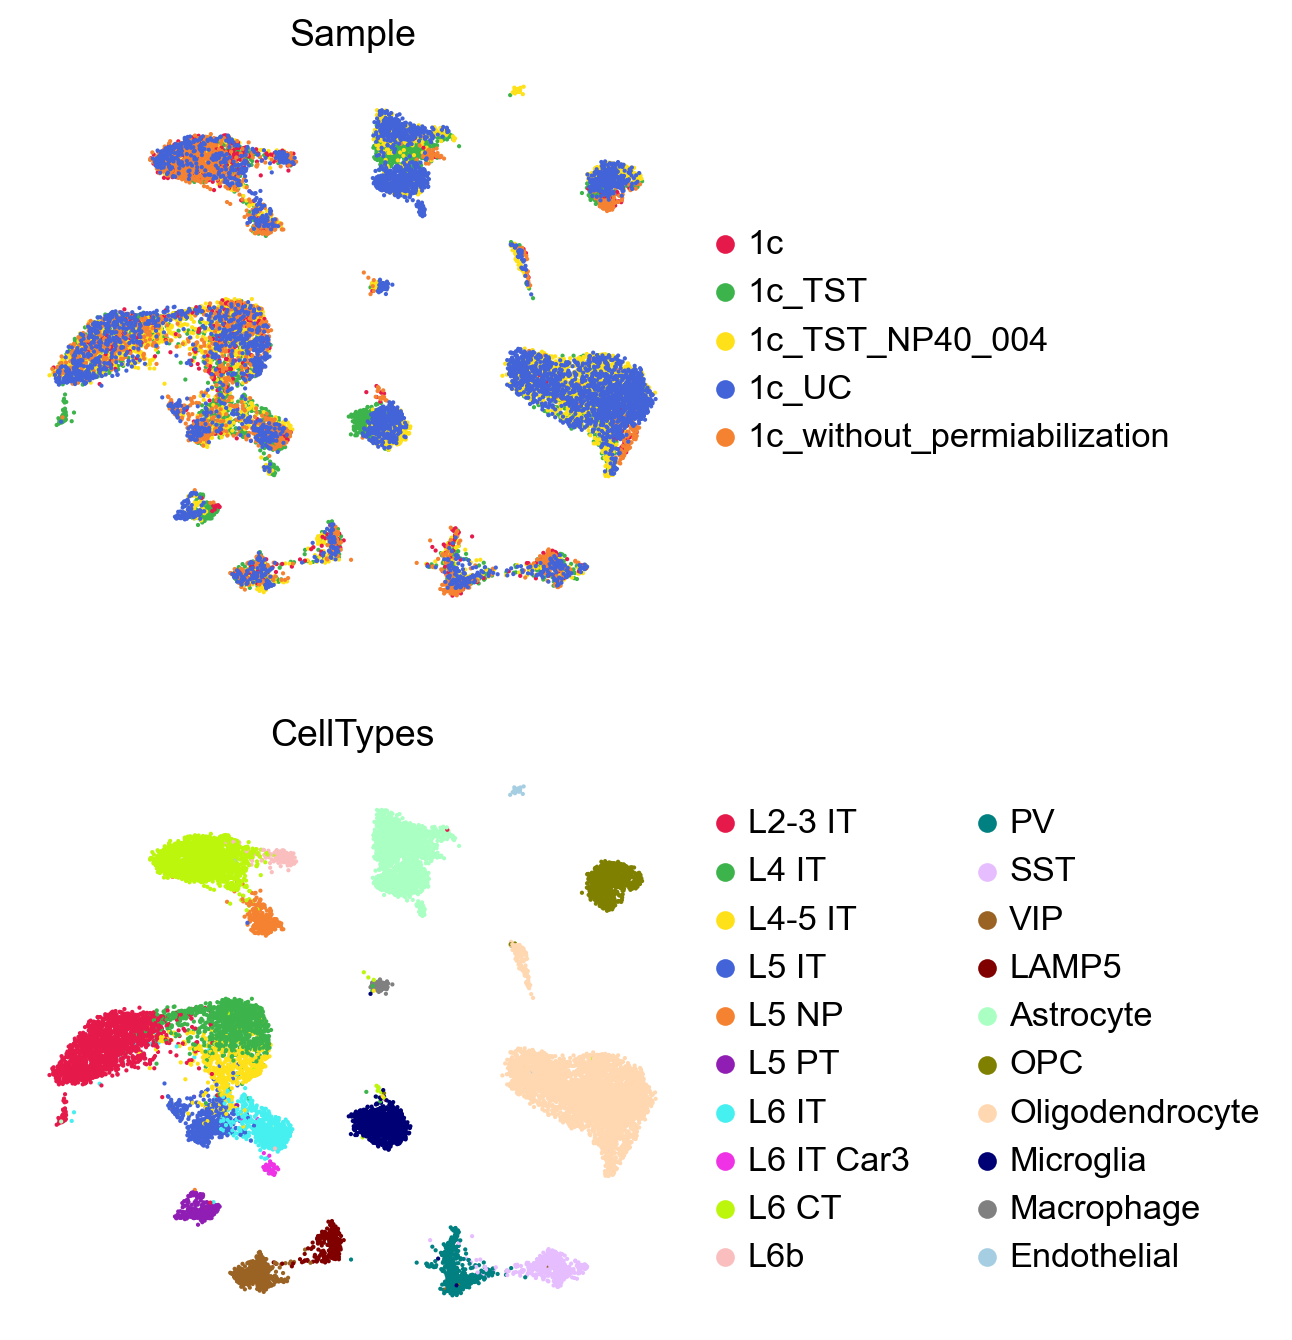

In [11]:
sc.pl.umap(adata,
           color=['Sample','CellTypes'],
           palette=piaso.pl.color.d_color4,
           cmap=piaso.pl.color.c_color4,
           size=10,
           ncols=1,
           frameon=False)

GDR effectively integrates batches and separates cell types using only dimensionality reduction, without additional integration methods.